# Description
This challenge was designed specifically for the AI Tunisia Hack 2019, which takes place from 20 to 22 September. Welcome to the AI Tunisia Hack participants!

After AI Hack Tunisia, this competition will be re-opened as a Knowledge Challenge to allow others in the Zindi community to learn and test their skills.

Flight delays not only irritate air passengers and disrupt their schedules but also cause :

- a decrease in efficiency
- an increase in capital costs, reallocation of flight crews and aircraft
- an additional crew expenses
- As a result, on an aggregate basis, an airline's record of flight delays may have a negative impact on passenger demand.

`This competition aims to predict the estimated duration of flight delays per flight`

This solution proposes to build a flight delay predictive model using Machine Learning techniques. The accurate prediction of flight delays will help all players in the air travel ecosystem to set up effective action plans to reduce the impact of the delays and avoid loss of time, capital and resources.

Variable definitions

- ID
- DATOP - Date of flight
- FLTID - Flight number
- DEPSTN - Departure point
- ARRSTN - Arrival point
- STD - Scheduled Time departure
- STA - Scheduled Time arrival
- STATUS - Flight status
- AC - Aircraft Code

source: [https://zindi.africa/competitions/ai-tunisia-hack-5-predictive-analytics-challenge-2/](https://zindi.africa/competitions/ai-tunisia-hack-5-predictive-analytics-challenge-2/)

Additionally, we use a dataset giving information about the airports.
[https://pypi.org/project/airportsdata/](https://pypi.org/project/airportsdata/) 

---

# Content
- Import dataset and get first insights
- Numeric feature generation
- Visualize data
- Save cleaned dataframe

---

## Import dataset and get first insights

In [62]:
# import the necessary libraries we need for your analysis
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from project_fun import outcome, get_airport_info


RSEED =  42

In [63]:
# Import dataset

df = pd.read_csv('data/Train.csv',parse_dates=['DATOP','STD']) # 'STA' is not recognized due to . instead of :
df

,ID,DATOP,FLTID,DEPSTN,ARRSTN,STD,STA,STATUS,AC,target
0,train_id_0,2016-01-03,TU 0712,CMN,TUN,2016-01-03 10:30:00,2016-01-03 12.55.00,ATA,TU 32AIMN,260.0
1,train_id_1,2016-01-13,TU 0757,MXP,TUN,2016-01-13 15:05:00,2016-01-13 16.55.00,ATA,TU 31BIMO,20.0
2,train_id_2,2016-01-16,TU 0214,TUN,IST,2016-01-16 04:10:00,2016-01-16 06.45.00,ATA,TU 32AIMN,0.0
3,train_id_3,2016-01-17,TU 0480,DJE,NTE,2016-01-17 14:10:00,2016-01-17 17.00.00,ATA,TU 736IOK,0.0
4,train_id_4,2016-01-17,TU 0338,TUN,ALG,2016-01-17 14:30:00,2016-01-17 15.50.00,ATA,TU 320IMU,22.0
...,...,...,...,...,...,...,...,...,...,...
107828,train_id_107828,2018-07-05,WKL 0000,TUN,TUN,2018-07-05 23:00:00,2018-07-06 02.00.00,SCH,TU 32AIML,0.0
107829,train_id_107829,2018-01-13,UG 0003,DJE,TUN,2018-01-13 08:00:00,2018-01-13 09.00.00,SCH,UG AT7AT7,0.0
107830,train_id_107830,2018-11-07,SGT 0000,TUN,TUN,2018-11-07 05:00:00,2018-11-07 12.50.00,SCH,TU 736IOK,0.0
107831,train_id_107831,2018-01-23,UG 0010,TUN,DJE,2018-01-23 18:00:00,2018-01-23 18.45.00,ATA,TU CR9ISA,0.0


Here, we already see some notable facts: 

- in the column 'STA' the time is separated by dots rather than colons
- there appear to be flights where both arrival and departure destination are the same (TUN) and having flight numbers indicating some US link

    - SGT: Stuttgart Municipal Airport (Arkansas, USA)
    - WKL: Waikoloa Airport (Hawaii, USA)

Lacking any domain knowledge, we won't go into any interpretion.

In [64]:
# So, what size does the dataset has?
print("\n", f"The dataset has {df.shape[0]} rows and {df.shape[1]} columns.", "\n")

# Now, let us take a view to the columns and their type:
df.info()


 The dataset has 107833 rows and 10 columns. 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 107833 entries, 0 to 107832
Data columns (total 10 columns):
 #   Column  Non-Null Count   Dtype         
---  ------  --------------   -----         
 0   ID      107833 non-null  object        
 1   DATOP   107833 non-null  datetime64[ns]
 2   FLTID   107833 non-null  object        
 3   DEPSTN  107833 non-null  object        
 4   ARRSTN  107833 non-null  object        
 5   STD     107833 non-null  datetime64[ns]
 6   STA     107833 non-null  object        
 7   STATUS  107833 non-null  object        
 8   AC      107833 non-null  object        
 9   target  107833 non-null  float64       
dtypes: datetime64[ns](2), float64(1), object(7)
memory usage: 8.2+ MB


As we can see, the dataset has about 100,000 observations (i.e. flights) and 9 features. Besides three columns carrying date related information, all features are of type 'object'. This is a particular challenge to face as we want to perform a **regression** to predict flight delays. Furthermore, we see that all entries are non-null, meaning that there are no missing values (None, NaN, etc.).

In [65]:
# How many unique entries do the features have?
df.nunique()

ID        107833
DATOP       1011
FLTID       1861
DEPSTN       132
ARRSTN       128
STD        81697
STA        85136
STATUS         5
AC            68
target       968
dtype: int64

In [66]:
# Estimate time period of observations
print('First date: ', df['DATOP'].min())
print('Last date: ', df['DATOP'].max())

First date:  2016-01-01 00:00:00
Last date:  2018-12-31 00:00:00


So, our dataset includes the year 2016-2018 with 1011 different dates when flights took place. Overall about 130 individual airports were used either as arrival or departure destination. There are ca 1,800 individual flight numbers and 68 different aircraft codes indicating information about the manufacturer and model of the plane.

In [67]:
# Check for duplicated values
df.duplicated().unique()

array([False])

## Numeric feature generation

As all of our features are non-numeric, we need to transform the features to get numeric columns to work with. To do so, we will split 
some features having date-specific information into year, month, day etc. In addition, we will load a supplementary file having more information about the airports, such as latitude, longitude, elevation and country.

To proceed, we create a copy of the dataframe and apply changes to the columns.

In [68]:
df_cleaned = df.copy()

In [69]:
# Replace . with : and convert it to datetime object
df_cleaned['STA'] = df_cleaned['STA'].apply(lambda x: x.replace('.',':'))
df_cleaned['STA'] = pd.to_datetime(df_cleaned['STA'])

# alternatives:
# df['STA'].replace('\.',':', regex=True,inplace=True)
# df_cleaned['STA_test'] = df_cleaned['STA'].str.replace('.',':')

In [70]:
# Create years, month etc.
df_cleaned['hour_STA'] = df_cleaned.STA.dt.hour
df_cleaned['hour_STD'] = df.STD.dt.hour
df_cleaned['month'] = df.DATOP.dt.month
df_cleaned['year'] = df.DATOP.dt.year
df_cleaned['day_of_week'] = df.DATOP.dt.day_of_week # The day of the week with Monday=0, Sunday=6
df_cleaned['scheduled_time_duration'] = (df_cleaned['STA']-df_cleaned['STD']).dt.total_seconds()/60 # planed flight duration

In [71]:
# Add 'season' column by converting months into seasons
df_cleaned.loc[(df_cleaned['month'] >= 3) & (df_cleaned['month'] < 6), 'season'] = "spring"
df_cleaned.loc[(df_cleaned['month'] >= 6) & (df_cleaned['month'] < 9), 'season'] = "summer"
df_cleaned.loc[(df_cleaned['month'] >= 9) & (df_cleaned['month'] < 12), 'season'] = "autumn"
df_cleaned.loc[(df_cleaned['month'] < 3) | (df_cleaned['month'] == 12), 'season'] = "winter"

In [72]:
# Add numeric 'season' feature
df_cleaned['season_num'] = df_cleaned['season']
df_cleaned['season_num'] = df_cleaned['season_num'].replace({'spring': 0, 'summer': 1, 'autumn': 2, 'winter': 3})

In [73]:
# Convert target column into categorical to get better idea
df_cleaned['outcome'] = df.target.apply(lambda x: outcome(x))

### Import airport data to add geographical information

In [74]:
# load dataset
df_air = pd.read_csv('data/airports.csv')
df_air

,icao,iata,name,city,subd,country,elevation,lat,lon,tz
0,00AK,NaN,Lowell Field,Anchor Point,Alaska,US,450,59.949200,-151.695999,America/Anchorage
1,00AL,NaN,Epps Airpark,Harvest,Alabama,US,820,34.864799,-86.770302,America/Chicago
2,00AZ,NaN,Cordes Airport,Cordes,Arizona,US,3810,34.305599,-112.165001,America/Phoenix
3,00CA,NaN,Goldstone /Gts/ Airport,Barstow,California,US,3038,35.350498,-116.888000,America/Los_Angeles
4,00CO,NaN,Cass Field,Briggsdale,Colorado,US,4830,40.622200,-104.344002,America/Denver
...,...,...,...,...,...,...,...,...,...,...
28878,ZYTN,TNH,Tonghua Sanyuanpu Airport,Tonghua,Jilin,CN,1200,42.253889,125.703333,Asia/Shanghai
28879,ZYTX,SHE,Taoxian Airport,Shenyang,Liaoning,CN,198,41.639801,123.483002,Asia/Shanghai
28880,ZYXC,XEN,Xingcheng Air Base,NaN,Liaoning,CN,30,40.580299,120.697998,Asia/Shanghai
28881,ZYYJ,YNJ,Yanji Chaoyangchuan Airport,Yanji,Jilin,CN,624,42.882801,129.451004,Asia/Shanghai


In [75]:
# Add new columns by using additional information about the airports
df_cleaned = get_airport_info(data=df_cleaned, data_air=df_air, location='ARRSTN', cols=['country','elevation','lat','lon'])
df_cleaned = get_airport_info(data=df_cleaned, data_air=df_air, location='DEPSTN', cols=['country','elevation','lat','lon'])

In [76]:
# Convert features elevation, lat and lon to numeric
df_cleaned['elevation_arr'] = df_cleaned['elevation_arr'].astype(int)
df_cleaned['lat_arr'] = df_cleaned['lat_arr'].astype(float)
df_cleaned['lon_arr'] = df_cleaned['lon_arr'].astype(float)
df_cleaned['elevation_dep'] = df_cleaned['elevation_dep'].astype(int)
df_cleaned['lat_dep'] = df_cleaned['lat_dep'].astype(float)
df_cleaned['lon_dep'] = df_cleaned['lon_dep'].astype(float)

In [77]:
# Remove ID as it is not useful and STATUS as it is has information gathered during or after the operation of the flights
df_cleaned.drop(['ID','STATUS'], axis=1, inplace=True)

In [78]:
df_cleaned

,DATOP,FLTID,DEPSTN,ARRSTN,STD,STA,AC,target,hour_STA,hour_STD,...,season_num,outcome,country_arr,elevation_arr,lat_arr,lon_arr,country_dep,elevation_dep,lat_dep,lon_dep
0,2016-01-03,TU 0712,CMN,TUN,2016-01-03 10:30:00,2016-01-03 12:55:00,TU 32AIMN,260.0,12,10,...,3,1,TN,22,36.851002,10.22720,MA,656,33.367500,-7.58997
1,2016-01-13,TU 0757,MXP,TUN,2016-01-13 15:05:00,2016-01-13 16:55:00,TU 31BIMO,20.0,16,15,...,3,1,TN,22,36.851002,10.22720,IT,768,45.630600,8.72811
2,2016-01-16,TU 0214,TUN,IST,2016-01-16 04:10:00,2016-01-16 06:45:00,TU 32AIMN,0.0,6,4,...,3,0,TR,325,41.275333,28.75200,TN,22,36.851002,10.22720
3,2016-01-17,TU 0480,DJE,NTE,2016-01-17 14:10:00,2016-01-17 17:00:00,TU 736IOK,0.0,17,14,...,3,0,FR,90,47.153198,-1.61073,TN,19,33.875000,10.77550
4,2016-01-17,TU 0338,TUN,ALG,2016-01-17 14:30:00,2016-01-17 15:50:00,TU 320IMU,22.0,15,14,...,3,1,DZ,82,36.691002,3.21541,TN,22,36.851002,10.22720
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
107167,2018-07-05,WKL 0000,TUN,TUN,2018-07-05 23:00:00,2018-07-06 02:00:00,TU 32AIML,0.0,2,23,...,1,0,TN,22,36.851002,10.22720,TN,22,36.851002,10.22720
107168,2018-01-13,UG 0003,DJE,TUN,2018-01-13 08:00:00,2018-01-13 09:00:00,UG AT7AT7,0.0,9,8,...,3,0,TN,22,36.851002,10.22720,TN,19,33.875000,10.77550
107169,2018-11-07,SGT 0000,TUN,TUN,2018-11-07 05:00:00,2018-11-07 12:50:00,TU 736IOK,0.0,12,5,...,2,0,TN,22,36.851002,10.22720,TN,22,36.851002,10.22720
107170,2018-01-23,UG 0010,TUN,DJE,2018-01-23 18:00:00,2018-01-23 18:45:00,TU CR9ISA,0.0,18,18,...,3,0,TN,19,33.875000,10.77550,TN,22,36.851002,10.22720


## Visualize data

Lets get some first visual impressions about the dataset - now as we have numeric features.

### How many flights did actually happen?

/Users/philipp/neuefische/nf-flight-delay/.venv/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


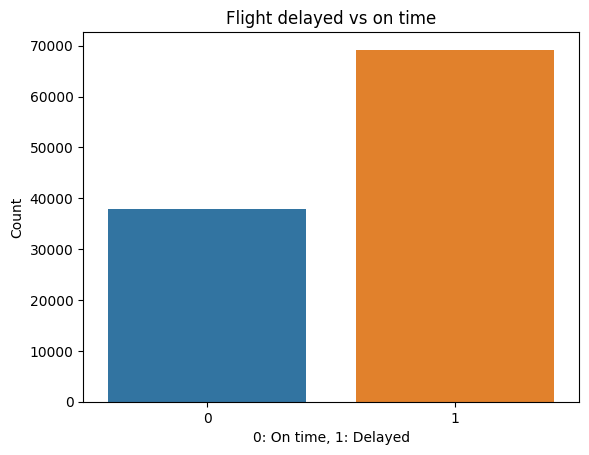

In [79]:
# plot ratio of delayed/non-delayed flights
flight_no = df_cleaned.groupby("outcome").size()
flight_plt = sns.barplot(flight_no.index, flight_no.values)
flight_plt.set(xlabel="0: On time, 1: Delayed", ylabel="Count", title="Flight delayed vs on time")
plt.show()

### Per week

/Users/philipp/neuefische/nf-flight-delay/.venv/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


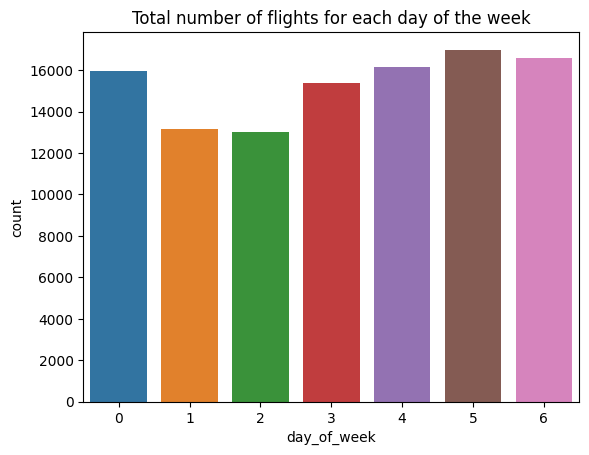

In [80]:
sns.countplot(df_cleaned['day_of_week'])
plt.title('Total number of flights for each day of the week');

/Users/philipp/neuefische/nf-flight-delay/.venv/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


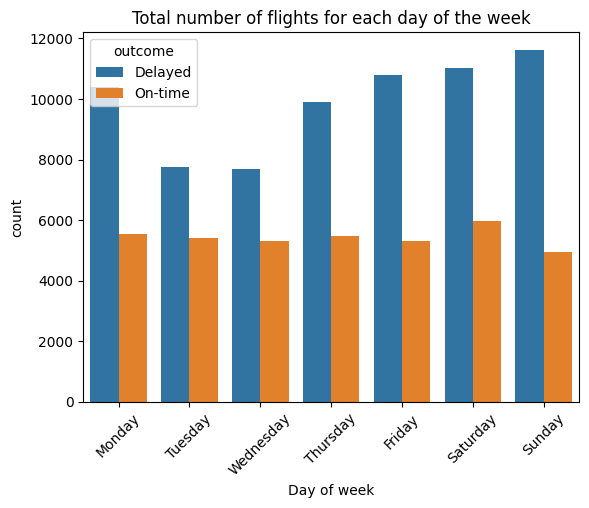

In [81]:
# plot of months with the delay in flights, where 1 displayed flight delay and 0 when the flight in on time
figure, ax = plt.subplots(1, 1)
sns.countplot(df_cleaned['day_of_week'], hue=df_cleaned['outcome'])
plt.legend(title='outcome', loc='upper left', labels=['Delayed', 'On-time'])
plt.title('Total number of flights for each day of the week');
plt.xlabel('Day of week')
plt.xticks(rotation=45)
ax.set_xticklabels( ('Monday', 'Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday') );


#### Per month

In [82]:
# How many flights occured each month?
df_cleaned['month'].value_counts()

8     13122
7     12140
6      9694
4      9553
10     9390
3      8946
12     8790
1      8612
11     7692
9      7350
5      6740
2      5143
Name: month, dtype: int64

/Users/philipp/neuefische/nf-flight-delay/.venv/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


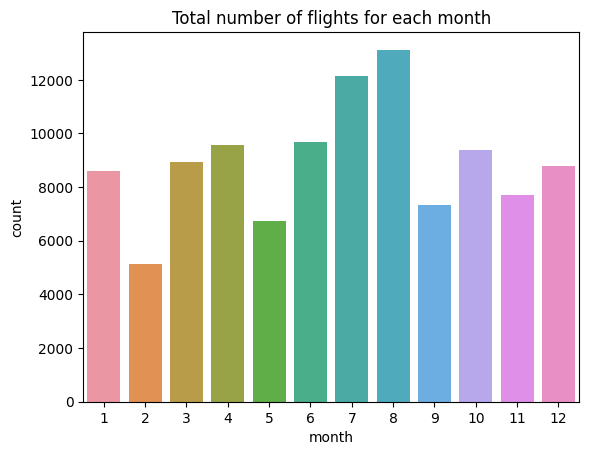

In [83]:
sns.countplot(df_cleaned['month'])
plt.title('Total number of flights for each month');

/Users/philipp/neuefische/nf-flight-delay/.venv/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


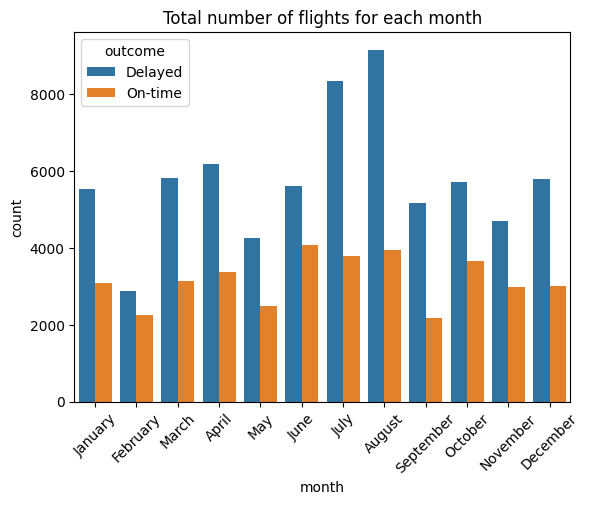

In [84]:
# plot of months with the delay in flights, where 1 displayed flight delay and 0 when the flight in on time
figure, ax = plt.subplots(1, 1)
sns.countplot(df_cleaned['month'], hue=df_cleaned['outcome'])
plt.legend(title='outcome', loc='upper left', labels=['Delayed', 'On-time'])
plt.title('Total number of flights for each month')
plt.xticks(rotation=45)
ax.set_xticklabels( ('January', 'February','March','April','May','June','July','August','September','October','November','December') );


#### Per season

/Users/philipp/neuefische/nf-flight-delay/.venv/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


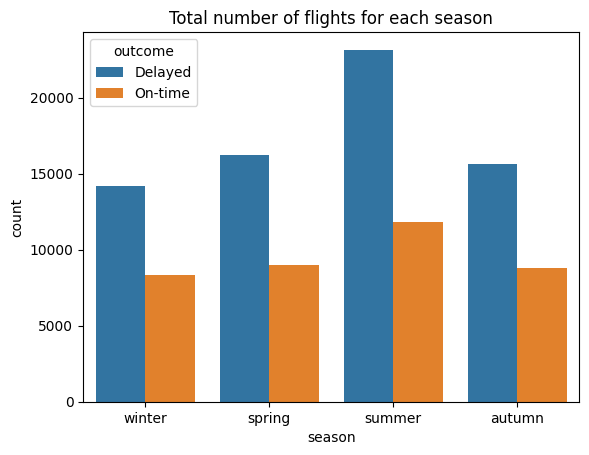

In [85]:
# plot delayed/non-delayed flights grouped by season
sns.countplot(df_cleaned['season'], hue=df_cleaned['outcome'])
plt.legend(title='outcome', loc='upper left', labels=['Delayed', 'On-time'])
plt.title('Total number of flights for each season');

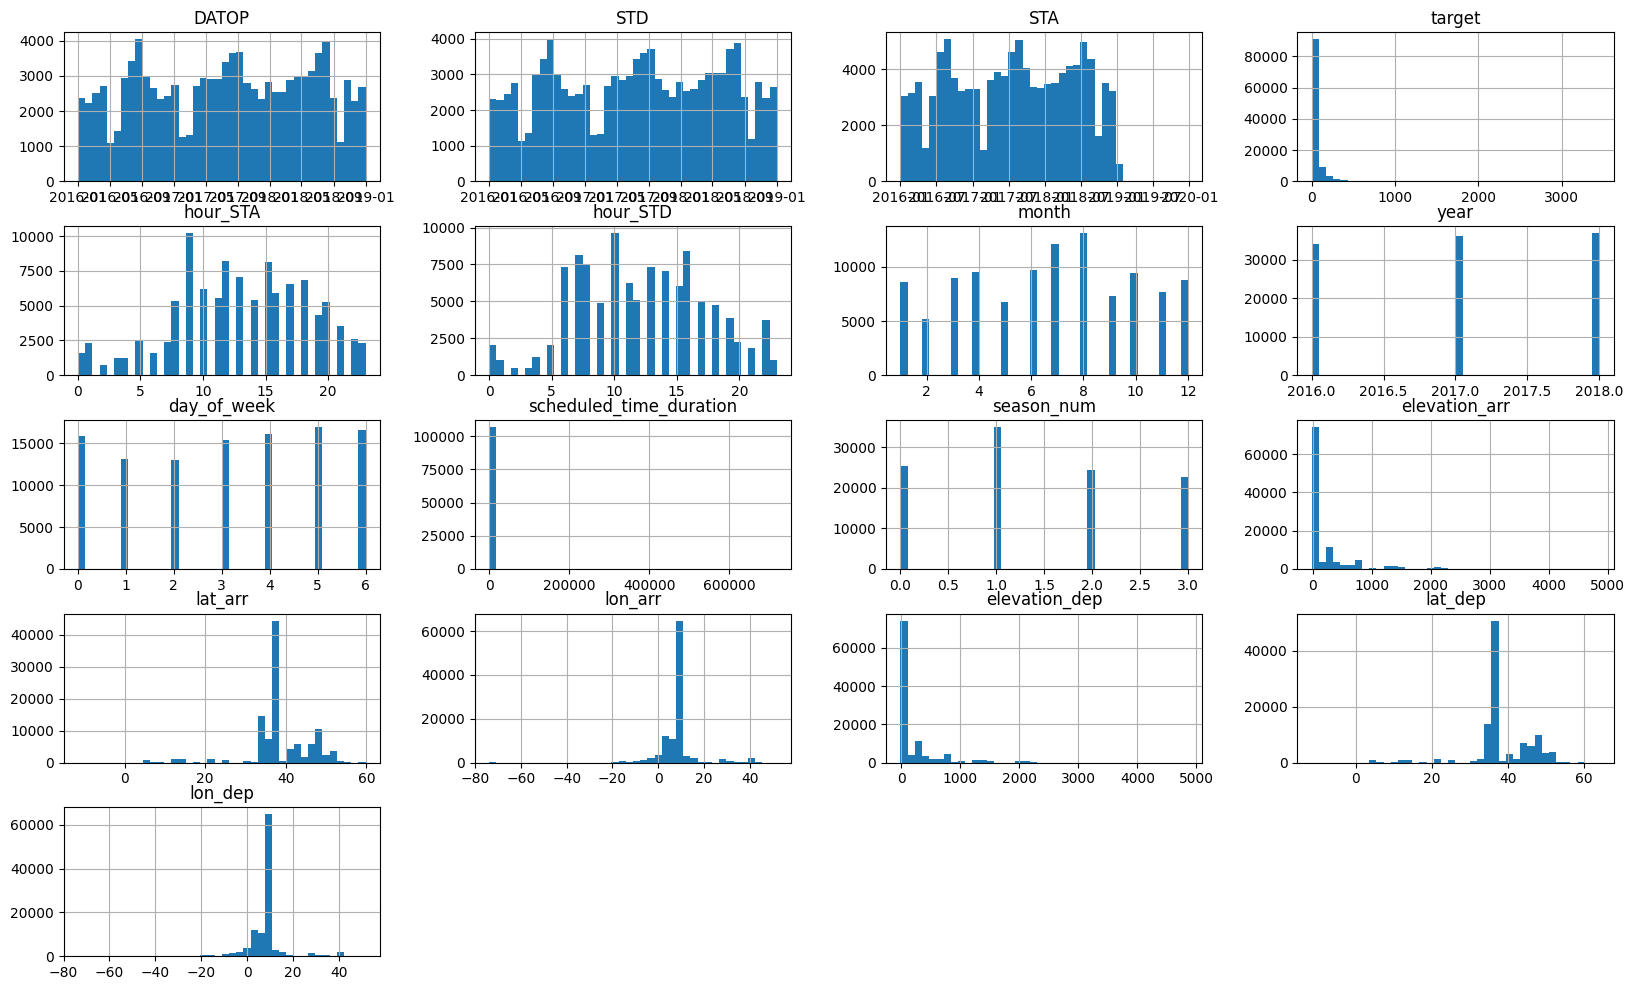

In [86]:
# plot histogram
df_cleaned.hist(bins=40, figsize=(20, 12))
plt.show()

### By how much were the flights delayed?

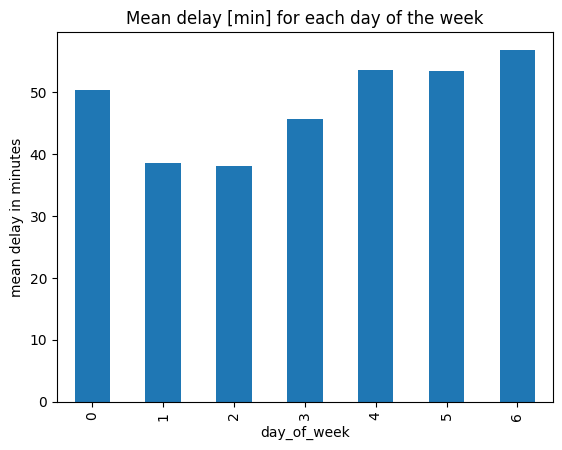

In [87]:
plt.figure()
df_cleaned.groupby('day_of_week')['target'].mean().plot(kind='bar')
plt.ylabel('mean delay in minutes')
plt.title('Mean delay [min] for each day of the week'); # 0: monday, 6: sunday

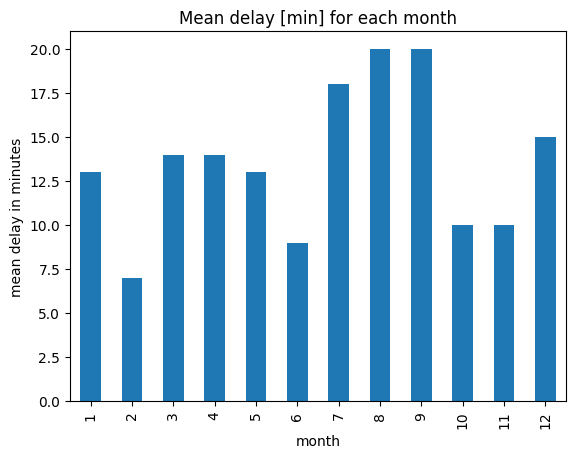

In [88]:
plt.figure()
df_cleaned.groupby('month')['target'].median().plot(kind='bar')
plt.ylabel('mean delay in minutes')
plt.title('Mean delay [min] for each month');

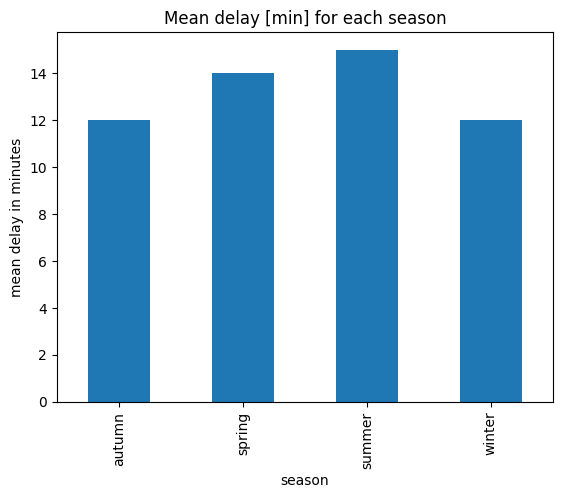

In [89]:
plt.figure()
df_cleaned.groupby('season')['target'].median().plot(kind='bar')
plt.ylabel('mean delay in minutes')
plt.title('Mean delay [min] for each season');

#### Correlation of features with the target

Now, we can create a correlation heatmap to estimate the correlation between the features and the target.

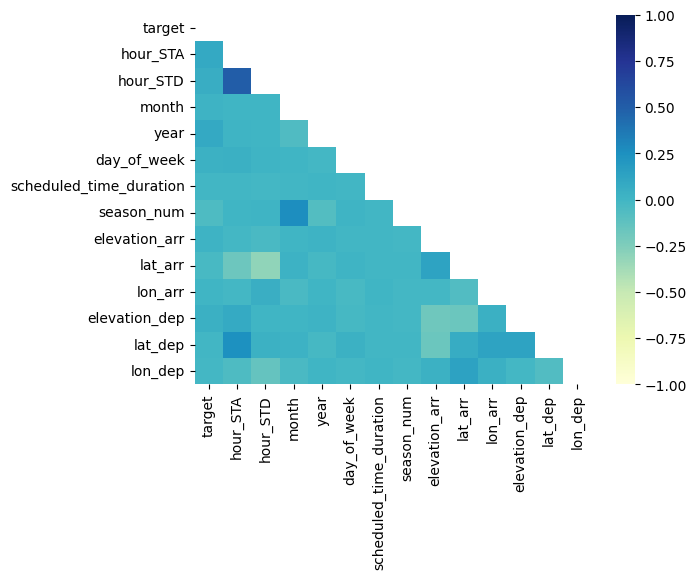

In [90]:
# Calculate correlation heatmap
correlations = df_cleaned.corr()
mask = np.triu(correlations)
sns.heatmap(correlations, vmax=1, vmin=-1, annot=False, mask=mask, cmap="YlGnBu");

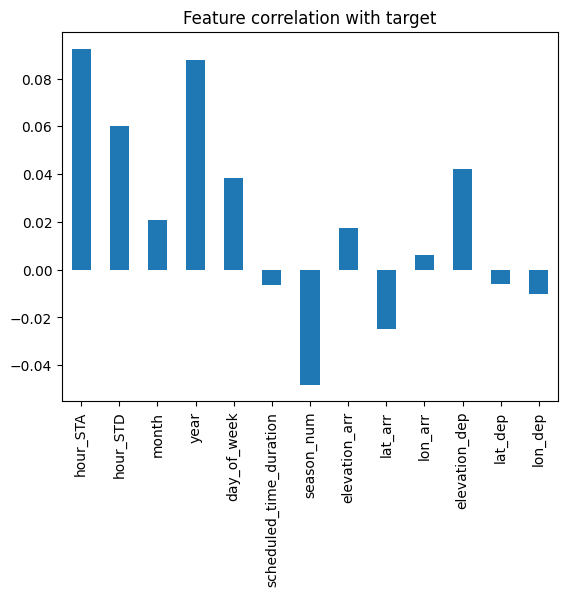

In [91]:
# Show only correlation with the target
t_corr = correlations['target']
t_corr.iloc[1:].plot(kind='bar', title='Feature correlation with target');

Overall the features show only weak correlation with the target. Despite, the features having most influence are:
- hour_STA (+0.093)
- year (+0.088)
- hour_STD (+0.060)
- season (-0.048)
- elevation_dep (+0.042)
- day_of_week (0.039)

For obvious reasons, we would exclude the year. As hour_STA and hour_STD are moderately correlated (+0.505) hour_STD may be neglected.

One can slightly increase the correlation by calculating the power of these features:

- hour_STA ** 3 has correlation of (+0.101)
- season ** 2 has correlation of (-0.052)
- day_of_week ** 2 has correlation of (+0.044)

## Save cleaned dataframe

In [92]:
#df_cleaned.to_csv('data/Train_cleaned.csv', sep=';', index=False)